In [1]:
import os, sys
print(os.listdir('../../'))
print(os.getcwd())
sys.path.append("../")
sys.path.append("../src/network")
sys.path.append("../src")
print(os.getcwd())
import torch
import glob
from torch import optim
import numpy as np
from src.data.tokenizer import Tokenizer
import string
import os, sys
import torch.utils.data as D
import cv2
import numpy as np
from torchvision import transforms
from src.network.gen_model.gen_model import GenModel_FC
from torchvision.transforms import v2
from random import choices
import kornia as K
import kornia.feature as KF
from kornia_moons.viz import *
from src.data.data_loader import RIMES_data
from src.data.reader import read_rimes
import random
import matplotlib.pyplot as plt
from src.network.losses import Loss
from src.network.sia_model.model import SiameseNetwork

['data', 'handwriting-recognition', 'htr_self_supervised', 'manuscript-dating-sn', 'mnist_pipeline', 'Paper-ext', 'self-supervised-mnist', 'Thesis', 'ws-siamese']
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\small_experiments
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\small_experiments


In [2]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
max_text_length = 25
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length, self_supervised=1)

In [3]:
gen_model = GenModel_FC(tokenizer.maxlen, tokenizer.vocab_size, tokenizer.PAD).cuda()
gen_model.load_state_dict(torch.load('../src/network/gen_model/gen_model-25half.model')) #load
gen_model.eval()

GenModel_FC(
  (enc_image): RecursiveScriptModule(
    original_name=ImageEncoder
    (model): RecursiveScriptModule(
      original_name=VGG
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=InstanceNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
        (3): RecursiveScriptModule(original_name=Conv2d)
        (4): RecursiveScriptModule(original_name=InstanceNorm2d)
        (5): RecursiveScriptModule(original_name=ReLU)
        (6): RecursiveScriptModule(original_name=Conv2d)
        (7): RecursiveScriptModule(original_name=InstanceNorm2d)
        (8): RecursiveScriptModule(original_name=ReLU)
        (9): RecursiveScriptModule(original_name=Conv2d)
        (10): RecursiveScriptModule(original_name=InstanceNorm2d)
        (11): RecursiveScriptModule(original_name=ReLU)
        (12): RecursiveScriptModule(original_name=MaxPool2d)
        (13):

In [4]:
sia_model = SiameseNetwork("resnet34", False).cuda()
sia_model.load_state_dict(torch.load('../src/network/sia_model/resnet34-RMS-6.model'))
sia_model.eval()

SiameseNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
input_size = (64, 216, 1)
num_style_imgs = 25 # num imgs for generator to extract style from
batch_size = 32
dataset = "iam"
dataset_path = os.path.join("..", "data", dataset, "words")
max_word_len = 10

In [6]:
data_train, data_valid, data_test, wid_train, wid_valid, wid_test = read_rimes(dataset_path, max_word_len)

train
number of words in train: 20552
number of wids in train: 499
Number of words per word length
2 4301
3 5306
4 4147
5 2841
6 2128
7 1829
valid
number of words in valid: 6112
number of wids in valid: 499
Number of words per word length
2 1281
3 1605
4 1264
5 808
6 637
7 517
test
number of words in test: 4892
number of wids in test: 499
Number of words per word length
2 1028
3 1288
4 984
5 663
6 495
7 434


In [7]:
data_train = RIMES_data(data_train, input_size=input_size, tokenizer=tokenizer, num_images=num_style_imgs, wids=wid_train)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)


distribution check

In [10]:
means_data = []
stds_data = []

means_synth = []
stds_synth = []

for batch in train_loader:
    imgs, gen_imgs, gt_labels, _ = batch
    gt_labels = torch.nn.functional.one_hot(gt_labels.long(), 56).float()

    imgs = imgs.to(device)
    gen_imgs = gen_imgs.to(device).squeeze(2)
    gt_labels = gt_labels.to(device)

    synth_imgs = gen_model(gen_imgs, gt_labels)

    means_data += torch.mean(imgs, dim=[2,3]).cpu().squeeze().numpy().tolist()
    means_synth += torch.mean(synth_imgs.detach(), dim=[2,3]).cpu().squeeze().numpy().tolist()

    stds_data += torch.std(imgs, dim=[2,3]).cpu().squeeze().numpy().tolist()
    stds_synth += torch.std(synth_imgs.detach(), dim=[2,3]).cpu().squeeze().numpy().tolist()
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


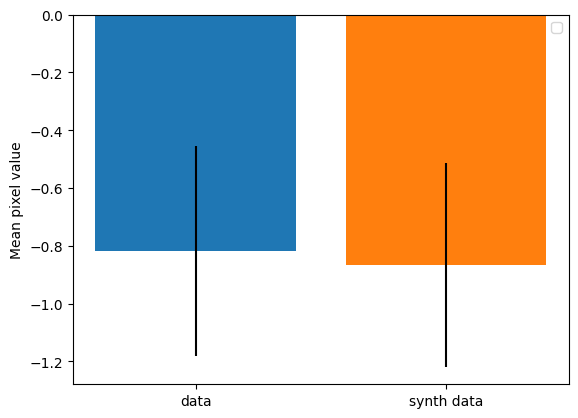

In [14]:
plt.bar(['data'], np.mean(means_data), yerr=np.mean(stds_data))
plt.bar(['synth data'], np.mean(means_synth), yerr=np.mean(stds_synth))
plt.ylabel('Mean pixel value')
# plt.xticks(labels=['data', 'synth data'])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


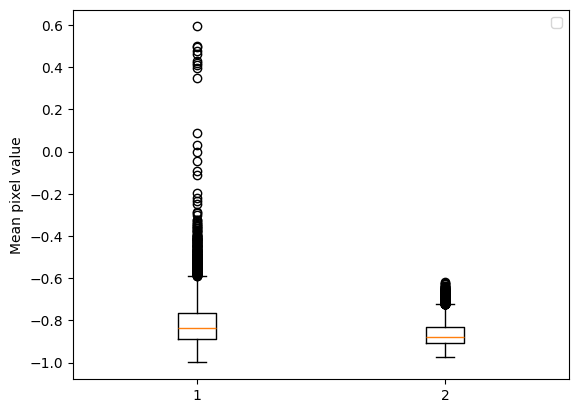

In [15]:
plt.boxplot([means_data,means_synth])
plt.ylabel('Mean pixel value')
# plt.xticks(labels=['data', 'synth data'])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


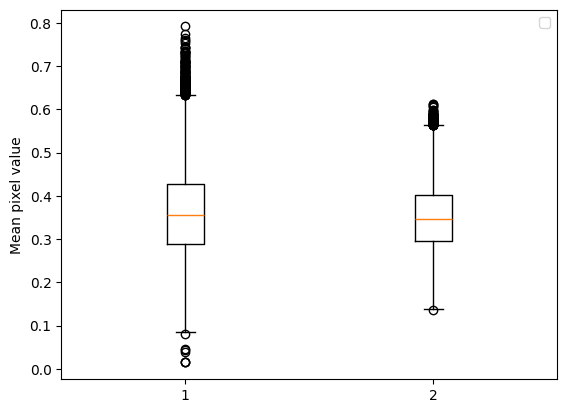

In [16]:
plt.boxplot([stds_data, stds_synth])
plt.ylabel('Mean pixel value')
# plt.xticks(labels=['data', 'synth data'])
plt.legend()
plt.show()

In [8]:
loss_name = "siamese"
loss_class = Loss(loss_name, tokenizer, device, 19)

In [27]:
character_freq_dict = {'a': 0.07946946670350925, 'b': 0.016137054434926777, 'c': 0.01769825918762089, 'd': 0.039748549323017406, 'e': 0.12830892511743575, 
                'f': 0.026554296767062724, 'g': 0.017463387676153633, 'h': 0.07033710969881182, 'i': 0.05732246476927328, 'j': 0.001091461729759602, 
                'k': 0.007667864050842774, 'l': 0.038643271621995025, 'm': 0.021566731141199225, 'n': 0.06417518651561205, 'o': 0.0803951367781155, 
                'p': 0.013539651837524178, 'q': 0.0005526388505111909, 'r': 0.053965183752417795, 's': 0.05815142304504007, 't': 0.09472229897761812, 
                'u': 0.023984526112185687, 'v': 0.008483006355346781, 'w': 0.025366123238463663, 'x': 0.0011605415860735009, 'y': 0.0206272450953302, 
                'z': 0.00030395136778115504, 'A': 0.001768444321635811, 'B': 0.0023210831721470018, 'C': 0.0013125172699640785, 'D': 0.000980933959657364, 
                'E': 0.0010638297872340426, 'F': 0.0013539651837524177, 'G': 0.0013539651837524177, 'H': 0.002680298424979276, 'I': 0.0016302846090080134, 
                'J': 0.0004973749654600719, 'K': 0.0003177673390439348, 'L': 0.0011467256148107211, 'M': 0.0015335728101685548, 'N': 0.0012158054711246201, 
                'O': 0.0008427742470295662, 'P': 0.0018789720917380493, 'Q': 6.907985631389887e-05, 'R': 0.000911854103343465, 'S': 0.001948051948051948, 
                'T': 0.004766510085659022, 'U': 0.0003177673390439348, 'V': 0.00024868748273003594, 'W': 0.0017546283503730312, 'X': 2.7631942525559546e-05, 
                'Y': 0.0006079027355623101, 'Z': 1.3815971262779773e-05}

char_weights = [character_freq_dict[char] for char in charset_base]

def random_insertion(text):
    idx = random.randint(0, len(text))
    char_in = random.choices(charset_base, weights=char_weights, k=1)
    return text[:idx] + char_in[0] + text[idx:]

def random_deletion(text):
    idx = random.randint(0, len(text) - 1)
    return text[:idx] + text[idx + 1:]

def random_swap(text):
    text = list(text)
    indices = random.choices([idx for idx in range(len(text))], k=2)
    temp = text[indices[0]]
    text[indices[0]] = text[indices[1]]
    text[indices[1]] = temp
    return ''.join(text)

def random_replacement(text):
    idx = random.randint(0, len(text) - 1)
    new_char = random.choices(charset_base, weights=char_weights, k=1)
    text = list(text)
    text[idx] = new_char[0]
    return ''.join(text)

def random_edits(text):
    edit_funcs = [random_insertion, random_deletion, random_swap, random_replacement]
    edits = random.choices(edit_funcs, k=3)
    text = edits[0](text)
    text = edits[1](text)
    return text

def random_multi_insert(text):
    if len(text) > 2:
        num_pos = random.randint(1, 2)
    else:
        num_pos = 1
    for i in range(num_pos):
        idx = random.randint(0, len(text))
        char_in = text[-1] if idx == len(text) else text[idx]
        seq_in = char_in * random.randint(2, 5)
        text = text[:idx] + seq_in + text[idx:]
    return text[:25] if len(text) > 25 else text

def get_nonesense_label(word_len):

    if word_len == 0:
        return ''

    nonesense_label = random.choices(charset_base, weights=char_weights, k=word_len)
    return ''.join(nonesense_label)

### Same style, same or different content with synthetic images

In [29]:
losses_same_synth = []
losses_edits_synth = []
losses_nonesense_synth = []

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.random.seed(42)

for num_char in range(2, 8):

    for j in range(100):
        img_idx = np.random.randint(len(data_train.img_paths))
        img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

        while len(tokenizer.decode(gt_label)) != num_char:
            img_idx = np.random.randint(len(data_train.img_paths))
            img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)
        

        edits_label = random_edits(tokenizer.decode(gt_label))
        while edits_label == tokenizer.decode(gt_label) or len(edits_label) == 0:
            edits_label = random_edits(tokenizer.decode(gt_label))

        if random.random() <= 0.25:
            edits_label = random_multi_insert(edits_label)
    
        nonesense_label = get_nonesense_label(num_char)
        if random.random() <= 0.25:
            nonesense_label = random_multi_insert(nonesense_label)
        

        print(tokenizer.decode(gt_label), edits_label, nonesense_label)
        edits_label = tokenizer.encode(edits_label)
        nonesense_label = tokenizer.encode(nonesense_label)
        
        synth_imgs = []

        label = torch.from_numpy(np.array(gt_label)).cuda().long()
        label = torch.nn.functional.one_hot(label, 56).float()

        edits_label_1hot = torch.from_numpy(np.array(edits_label)).cuda().long()
        edits_label_1hot = torch.nn.functional.one_hot(edits_label_1hot, 56).float()

        nonesense_label_1hot = torch.from_numpy(np.array(nonesense_label)).cuda().long()
        nonesense_label_1hot = torch.nn.functional.one_hot(nonesense_label_1hot, 56).float()

        loss_same_sum = 0
        loss_edits_sum = 0
        loss_nonesense_sum = 0

        for i in range(50):
            _, gen_input, _, _ = data_train.__getitem__(img_idx)           

            gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()

            synth_img = gen_model(gen_input, label.unsqueeze(0))
            synth_img_edits = gen_model(gen_input, edits_label_1hot.unsqueeze(0))
            synth_img_nonesense = gen_model(gen_input, nonesense_label_1hot.unsqueeze(0))

            img = img.cuda()

            loss_same_sum += loss_class.loss_func(synth_img, img).detach().cpu()
            loss_edits_sum += loss_class.loss_func(synth_img_edits, img).detach().cpu()
            loss_nonesense_sum += loss_class.loss_func(synth_img_nonesense, img).detach().cpu()

        losses_same_synth.append(loss_same_sum/50)
        losses_edits_synth.append(loss_edits_sum/50)
        losses_nonesense_synth.append(loss_nonesense_sum/50)

# plt.plot(losses_same_synth, label="same word")
# plt.plot(losses_edits_synth, label='edits')
# plt.plot(losses_nonesense_synth, label='random gen')
# plt.legend()
# plt.xlabel("Num of images")
# plt.ylabel("L2 between features siamese network")
# plt.title("L2 between siamese network features of same- and edits/random gen word images (synthetic)")
# plt.savefig(f"./{loss_name}_loss_data_synth_edits_random.png", dpi=300, bbox_inches="tight")
# plt.show()

of y ytttt
of fo tL
of o aaaaae
be nbe ea
of omdddddddd ef
de dte re
to nteo ro
it ait nl
in ih ad
of o bffffff
by db lk
of fr dr
of o tt
so T dn
to so eh
as a sl
It Itre taaa
it sht ri
of vo po
of oef nd
in iain nccc
to t ei
in piii sf
by b on
go gu od
to tooooooot mr
me he io
to oet ne
of ao tl
of efffffffffo vd
an tn pr
of fffffo ah
we iiieeeeew es
he rehhhhhh ev
by n eh
of rrrrr ci
to ot af
in le ur
be ebo rl
of eof sl
Of f eh
of so ed
as uuuuus ni
of oca etttt
do ddddddor nnnnnna
of ef ie
is gggggg aaaaad
in nih nt
an n it
He Ha ps
to toc tnnn
in inn ni
he hes oe
he eh eiiiiii
to ottttm nh
we wr pt
it iu ssssa
in a oD
in oiii bt
as asi hb
as vs mhhhh
of yo ev
of o fn
of ef oo
of oooooo hn
as ae mv
by y IIIIIb
he e sh
it nit ca
of ft as
be eeeee sa
of Pffffff rf
of fod om
to no sssssg
to o jw
of oobf rrrrn
is si dk
be b eiiiii
to t ed
in oi ae
of oof ee
it sti neeeee
of co dt
to pto em
of n Tttt
to taaaaaaaae ie
an bn th
He oeHHHH fb
at atn li
us wso bt
in ien is
he leeeeee yo
An A

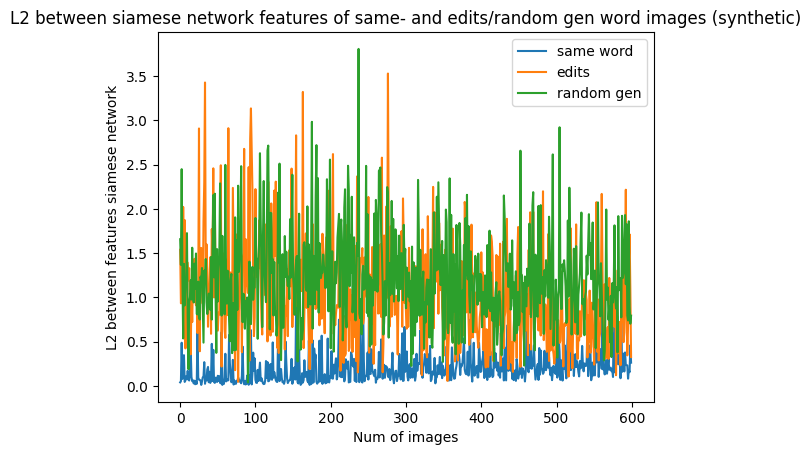

In [30]:
plt.plot(losses_same_synth, label="same word")
plt.plot(losses_edits_synth, label='edits')
plt.plot(losses_nonesense_synth, label='random gen')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("L2 between features siamese network")
plt.title("L2 between siamese network features of same- and edits/random gen word images (synthetic)")
plt.savefig(f"./{loss_name}_loss_data_synth_edits_random.png", dpi=300, bbox_inches="tight")
plt.show()

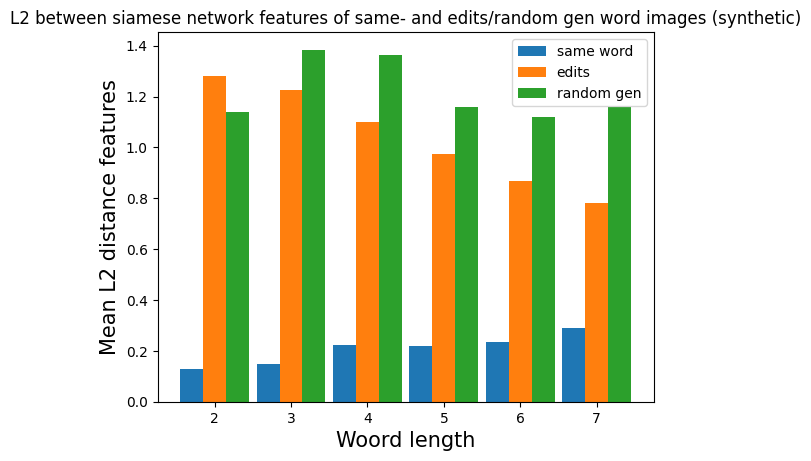

In [37]:
means_per_word_len_samesynth = [np.mean(losses_same_synth[i*100:(i+1)*100]) for i in range(6)]
means_per_word_len_editsynth = [np.mean(losses_edits_synth[i*100:(i+1)*100]) for i in range(6)]
means_per_word_len_nonesensesynth = [np.mean(losses_nonesense_synth[i*100:(i+1)*100]) for i in range(6)]

std_per_word_len_samesynth = [np.std(losses_same_synth[i*100:(i+1)*100]) for i in range(6)]
std_per_word_len_editsynth = [np.std(losses_edits_synth[i*100:(i+1)*100]) for i in range(6)]
std_per_word_len_nonesensesynth = [np.std(losses_nonesense_synth[i*100:(i+1)*100]) for i in range(6)]

barWidth = 0.3

 
# set height of bar 
 
# Set position of bar on X axis 
br1 = np.arange(len(means_per_word_len_samesynth)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

plt.bar(br1, means_per_word_len_samesynth, width=barWidth, label="same word")
plt.bar(br2, means_per_word_len_editsynth, width=barWidth, label="edits")
plt.bar(br3, means_per_word_len_nonesensesynth, width=barWidth, label='random gen')
plt.legend()
plt.xlabel('Woord length', fontsize = 15) 
plt.ylabel('Mean L2 distance features', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(means_per_word_len_samesynth))], 
        ['2', '3', '4', '5', '6', '7'])
plt.title("L2 between siamese network features of same- and edits/random gen word images (synthetic)")
plt.savefig(f"./{loss_name}_loss_data_synth_edits_random-barplot.png", dpi=300, bbox_inches="tight")
plt.show()

207 209
of of
343 093
be of
552 334
de to
247 183
it in
034 339
of by
286 011
of of
217 107
so to
150 166
It it
090 169
of of
549 334
in to
173 671
in by
543 000
to me
209 090
to of
000 165
an of
330 174
we he
163 210
by of
339 040
to in
000 093
be of
583 260
Of of
332 341
as of
129 549
do of
552 160
is in
333 155
an He
522 086
to in
620 344
he he
333 094
to we
197 123
in in
094 114
as as
283 251
of of
263 256
of as
617 216
by he
343 207
it of
293 671
of of
112 278
to to
293 545
of is
338 334
be to
198 037
in of
238 202
of to
344 118
of to
293 056
an He
081 155
us in
015 336
he An
240 338
at so
302 520
if It
107 665
it my
537 235
is an
635 584
me as
651 000
at we
660 556
of up
152 000
of to
174 158
to of
563 550
my of
287 331
up of
340 202
in It
341 254
be on
525 126
or By
671 191
ne in
342 612
at is
301 585
me Dr
038 248
no It
000 288
of to
626 671
of to
156 217
as in
305 341
he by
246 248
is by
104 595
to de
193 568
on in
313 519
at if
594 223
is no
130 000
of to
256 339
at on
337 33

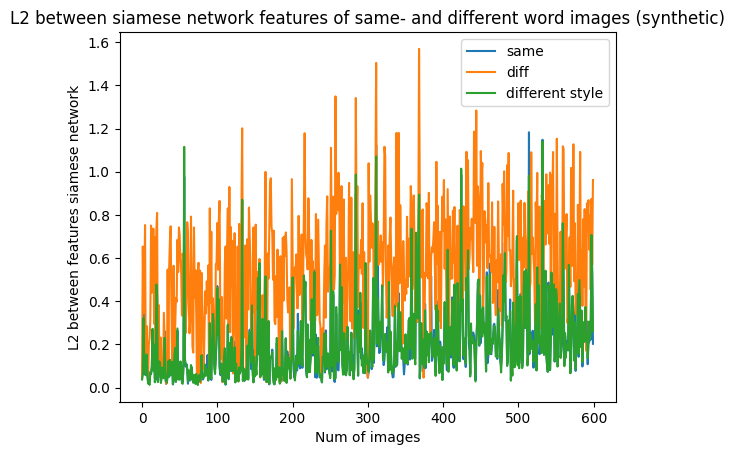

In [38]:
losses_same_synth = []
losses_diff_synth = []
losses_diff_s_synth = []
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.random.seed(42)

for num_char in range(2, 8):

    for j in range(100):
        img_idx = np.random.randint(len(data_train.img_paths))
        img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

        while len(tokenizer.decode(gt_label)) != num_char:
            img_idx = np.random.randint(len(data_train.img_paths))
            img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)
        
        img_idx_diff = np.random.randint(len(data_train.img_paths))
        _, _, gt_label_diff, _ = data_train.__getitem__(img_idx_diff)

        while (len(tokenizer.decode(gt_label_diff)) != num_char) and (tokenizer.decode(gt_label_diff) != tokenizer.decode(gt_label)):
            img_idx_diff = np.random.randint(len(data_train.img_paths))
            _, _, gt_label_diff, _ = data_train.__getitem__(img_idx_diff)
        
        tries = 0
        while True:
            img_idx_diff_s = np.random.randint(len(data_train.img_paths))
            _, gen_input_diff, _, wid_diff_s = data_train.__getitem__(img_idx_diff_s)
            print(wid_diff_s, wid)
            tries += 1
            if wid_diff_s != wid:
                break

        
        print(tokenizer.decode(gt_label), tokenizer.decode(gt_label_diff))
        synth_imgs = []

        label = torch.from_numpy(np.array(gt_label)).cuda().long()
        label = torch.nn.functional.one_hot(label, 56).float()

        label_diff = torch.from_numpy(np.array(gt_label_diff)).cuda().long()
        label_diff = torch.nn.functional.one_hot(label_diff, 56).float()
        loss_same_sum = 0
        loss_diff_sum = 0
        loss_diff_s_sum = 0

        for i in range(60):
            _, gen_input, _, _ = data_train.__getitem__(img_idx)   
            _, gen_input_diff, _, _ = data_train.__getitem__(img_idx_diff_s)            

            gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()
            gen_input_diff = torch.from_numpy(gen_input_diff).squeeze(1).unsqueeze(0).cuda()

            synth_img = gen_model(gen_input, label.unsqueeze(0))
            synth_img_diff = gen_model(gen_input, label_diff.unsqueeze(0))
            synth_img_diff_s = gen_model(gen_input_diff, label.unsqueeze(0))

            img = img.cuda()

            loss_same_sum += loss_class.loss_func(synth_img, img).detach().cpu()
            loss_diff_sum += loss_class.loss_func(synth_img_diff, img).detach().cpu()
            loss_diff_s_sum += loss_class.loss_func(synth_img_diff_s, img).detach().cpu()

        losses_same_synth.append(loss_same_sum/60)
        losses_diff_synth.append(loss_diff_sum/60)
        losses_diff_s_synth.append(loss_diff_s_sum/60)

plt.plot(losses_same_synth, label="same")
plt.plot(losses_diff_synth, label='diff')
plt.plot(losses_diff_s_synth, label='different style')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("L2 between features siamese network")
plt.title("L2 between siamese network features of same- and different word images (synthetic)")
plt.savefig(f"./{loss_name}_loss_data_synth.png", dpi=300, bbox_inches="tight")
plt.show()
    


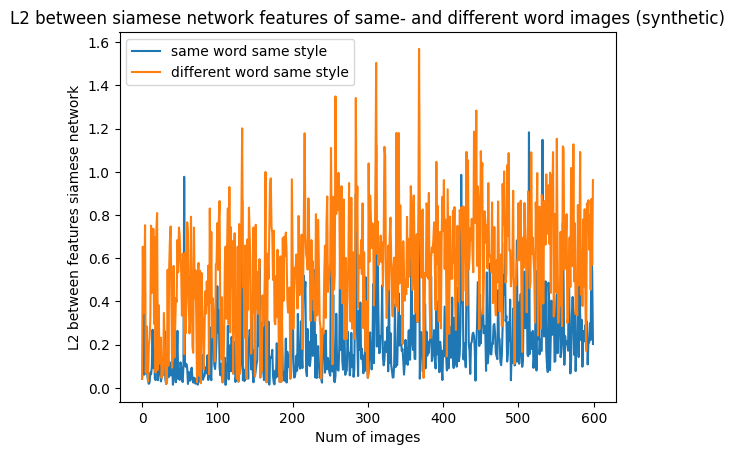

In [39]:
plt.plot(losses_same_synth, label="same word same style")
plt.plot(losses_diff_synth, label='different word same style')
# plt.plot(losses_diff_s_synth, label='different style')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("L2 between features siamese network")
plt.title("L2 between siamese network features of same- and different word images (synthetic)")
plt.savefig(f"./{loss_name}_loss_data_synth.png", dpi=300, bbox_inches="tight")
plt.show()

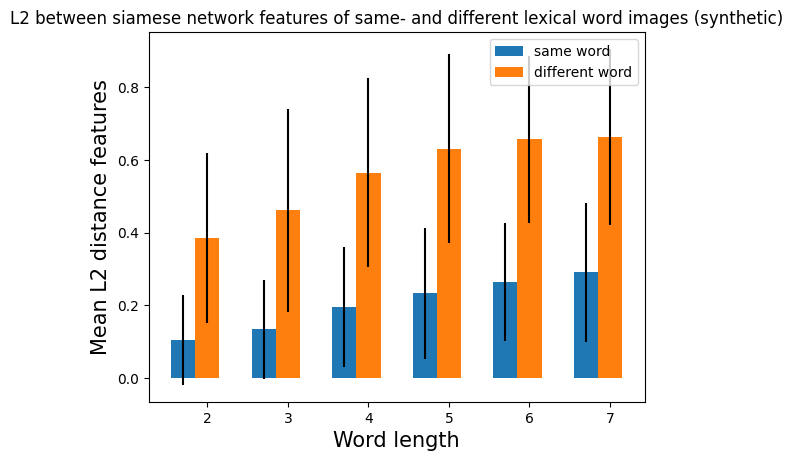

In [40]:
means_per_word_len_same_synth = [np.mean(losses_same_synth[i*100:(i+1)*100]) for i in range(6)]
means_per_word_len_diff_synth = [np.mean(losses_diff_synth[i*100:(i+1)*100]) for i in range(6)]

std_per_word_len_same_synth = [np.std(losses_same_synth[i*100:(i+1)*100]) for i in range(6)]
std_per_word_len_diff_synth = [np.std(losses_diff_synth[i*100:(i+1)*100]) for i in range(6)]

barWidth = 0.3
 
# Set position of bar on X axis 
br1 = np.arange(len(means_per_word_len_same_synth)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, means_per_word_len_same_synth, width=barWidth, yerr = std_per_word_len_same_synth, label="same word")
plt.bar(br2, means_per_word_len_diff_synth, width=barWidth, yerr = std_per_word_len_diff_synth, label="different word")
plt.legend()
plt.xlabel('Word length', fontsize = 15) 
plt.ylabel('Mean L2 distance features', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(means_per_word_len_same_synth))], 
        ['2', '3', '4', '5', '6', '7'])
plt.title("L2 between siamese network features of same- and different lexical word images (synthetic)")
plt.savefig(f"./{loss_name}_loss_data_synth_dff-barplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# np.save('./losses_samesynth.npy', losses_same_synth)
# np.save('./losses_diffsynth.npy', losses_diff_synth)
# np.save('./losses_samesynth_sstyle.npy', losses_diff_s_synth)

### Same style same or different content with real images

2
of 11
of 4
be 2
of 47
to 2
of 5
of 2
of 4
to 4
as 1
of 2
of 14
in 3
in 4
go 1
to 35
to 2
of 2
of 11
we 5
he 7
of 1
in 4
be 2
of 3
as 4
of 3
of 4
is 2
to 2
in 1
he 7
to 2
we 1
in 2
in 4
as 1
as 2
of 2
of 1
of 1
he 2
it 1
of 6
of 4
to 2
to 2
is 1
in 2
of 3
to 1
of 5
to 4
in 3
he 7
It 2
my 1
me 1
as 4
at 4
we 1
of 1
of 47
of 10
to 1
of 2
of 1
of 5
in 3
he 5
be 1
on 1
in 4
me 1
of 10
to 2
so 1
of 6
as 1
in 4
he 5
is 4
to 1
is 1
of 47
to 3
It 1
at 1
he 7
to 2
in 2
of 1
of 1
of 6
be 3
to 3
be 15
it 2
as 1
is 4
he 4
of 4
so 1
We 1
of 47
to 2
up 2
be 1
in 2
of 6
be 1
it 1
to 1
of 5
of 4
do 1
we 4
in 1
of 5
as 2
to 7
of 4
in 2
he 6
by 1
to 4
to 3
of 5
is 1
in 2
We 1
to 6
it 1
on 1
an 1
to 4
in 3
as 1
of 2
to 35
to 2
is 13
it 1
at 1
in 1
of 2
in 2
so 1
to 2
of 2
We 1
be 15
by 2
of 1
so 1
of 2
in 1
in 7
of 11
it 1
of 1
of 4
of 4
he 1
as 4
of 1
he 1
is 1
of 7
to 1
to 2
to 1
to 2
is 13
of 2
to 10
he 1
be 1
of 47
of 3
to 1
to 4
in 1
in 1
to 3
to 6
of 5
at 1
is 1
of 1
of 1
to 1
he 2
to 1
is 1
of 1


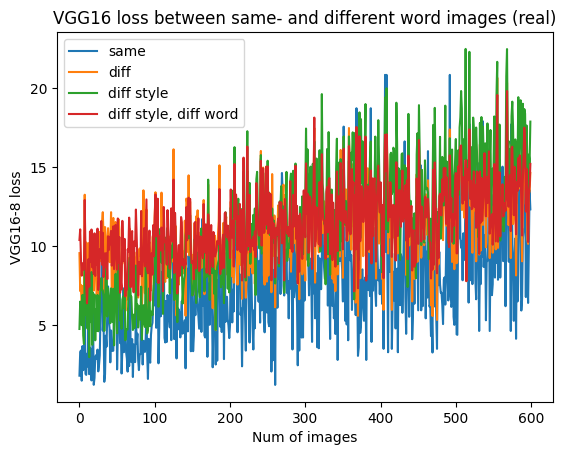

In [ ]:
losses_same_real = []
losses_diff_real = []
losses_diff_s_real = []
losses_diff_s_diff_real = []
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.random.seed(42)

for num_char in range(2, 8):
    print(num_char)

    for j in range(100):
        # img_idx = np.random.randint(len(data_train.img_paths))
        # img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

        # same_style = data_train.wids[wid]

        # same_word_paths = [item[0] for item in same_style if (item[1] == tokenizer.decode(gt_label)) and (item[0] != data_train.img_paths[img_idx][0])]
        # diff_word_paths = [item[0] for item in same_style if (item[1] != tokenizer.decode(gt_label)) and (len(item[1]) != len(tokenizer.decode(gt_label)))]
        
        tries = 0
        while True:
            img_idx = np.random.randint(len(data_train.img_paths))
            img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

            if len(tokenizer.decode(gt_label)) == num_char:
                same_style = data_train.wids[wid]
                text_label = tokenizer.decode(gt_label)

                same_word_paths = [item[0] for item in same_style if (item[1] == text_label) and (item[0] != data_train.img_paths[img_idx][0])]
                diff_word_paths = [item[0] for item in same_style if (item[1] != text_label) and (len(item[1]) != len(text_label))]

                if len(same_word_paths) >= 1:
                    break
            tries += 1

            if tries >= 5000:
                break

        print(tokenizer.decode(gt_label), len(same_word_paths))

        while True:
            img_idx = np.random.randint(len(data_train.img_paths))
            _, gen_input, gt_label_, wid_diff_s = data_train.__getitem__(img_idx)
            
            if wid_diff_s != wid:
                if len(tokenizer.decode(gt_label_)) == num_char:
                    
                    wid_style = data_train.wids[wid_diff_s]
                    same_word_paths_s = [item[0] for item in wid_style if (item[1] == tokenizer.decode(gt_label_)) and (item[0] != data_train.img_paths[img_idx][0])]
                    diff_word_paths_s = [item[0] for item in wid_style if (item[1] != text_label) and (len(item[1]) != len(text_label))]
                
                    if len(same_word_paths_s) >= 1:
                        break

        
        print(tokenizer.decode(gt_label_), len(same_word_paths_s))
        
        img = img.cuda()
        loss_same = 0
        if len(same_word_paths) >= 1:
            for path in same_word_paths:
                img_same = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_same = data_train.transforms(img_same).cuda()
                
                loss_same += loss_class.loss_func(img_same, img).detach().cpu()
            losses_same_real.append(loss_same/len(same_word_paths))
        
        loss_diff = 0
        if len(diff_word_paths) >= 1:
            for path in diff_word_paths:
                img_diff = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_diff = data_train.transforms(img_diff).cuda()
                loss_diff += loss_class.loss_func(img_diff, img).detach().cpu()
            losses_diff_real.append(loss_diff/len(diff_word_paths))
        
        loss_same_diff_s = 0
        if len(same_word_paths_s) >= 1:
            for path in same_word_paths_s:
                img_sames = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_sames = data_train.transforms(img_sames).cuda()
                loss_same_diff_s += loss_class.loss_func(img_sames, img).detach().cpu()
                
            losses_diff_s_real.append(loss_same_diff_s/len(same_word_paths_s))
        
        loss_diff_s = 0
        if len(diff_word_paths_s) >= 1:
            for path in diff_word_paths_s:
                img_diff_s = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img_diff_s = data_train.transforms(img_diff_s).cuda()
                loss_diff_s += loss_class.loss_func(img_diff_s, img).detach().cpu()
            losses_diff_s_diff_real.append(loss_diff_s/len(diff_word_paths_s))
            # print(losses_diff_s_real)

plt.plot(losses_same_real, label="same")
plt.plot(losses_diff_real, label='diff')
plt.plot(losses_diff_s_real, label="diff style")
plt.plot(losses_diff_s_diff_real, label="diff style, diff word")
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-8 loss")
plt.title("VGG16 loss between same- and different word images (real)")
plt.savefig("./vgg_loss_data_real.png")
plt.show()
    


In [ ]:
losses_same_synth = np.load('./losses_samesynth.npy')
losses_diff_synth = np.load('./losses_diffsynth.npy')
losses_diff_s_synth = np.load('./losses_samesynth_sstyle.npy')

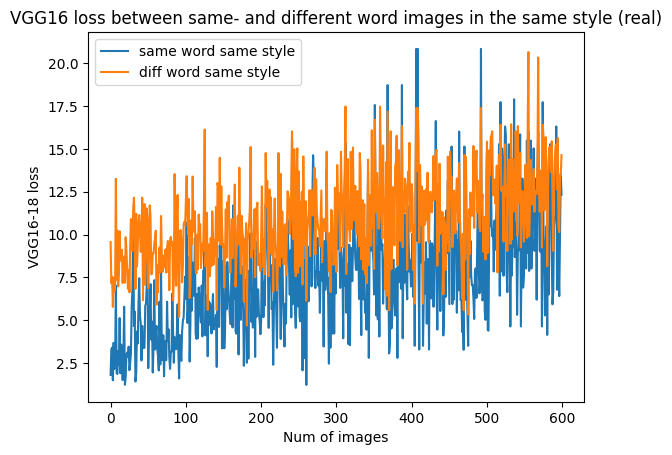

In [ ]:
plt.plot(losses_same_real, label="same word same style")
plt.plot(losses_diff_real, label='diff word same style')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-18 loss")
plt.title("VGG16 loss between same- and different word images in the same style (real)")
plt.savefig("./vgg_loss_data_real.png")
plt.show()

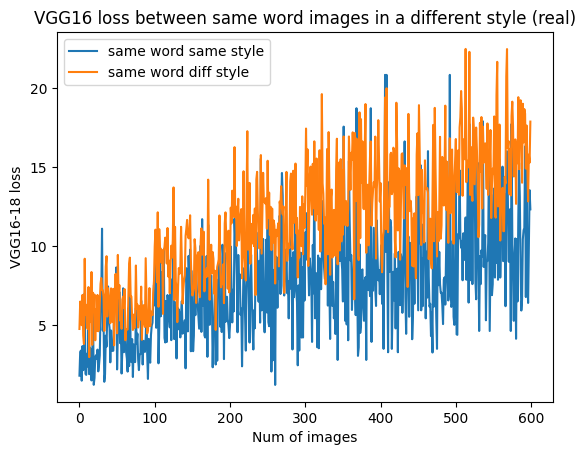

In [ ]:
plt.plot(losses_same_real, label="same word same style")
plt.plot(losses_diff_s_real, label="same word diff style")
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-18 loss")
plt.title("VGG16 loss between same word images in a different style (real)")
plt.savefig("./vgg_loss_data_real_diff_s.png")
plt.show()

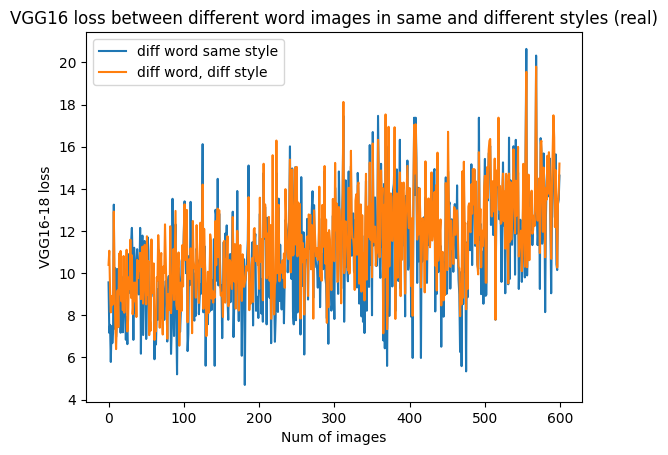

In [ ]:
plt.plot(losses_diff_real, label='diff word same style')
plt.plot(losses_diff_s_diff_real, label="diff word, diff style")

plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-18 loss")
plt.title("VGG16 loss between different word images in same and different styles (real)")
plt.savefig("./vgg_loss_data_real_diffwsames_diffwdiffs.png")
plt.show()

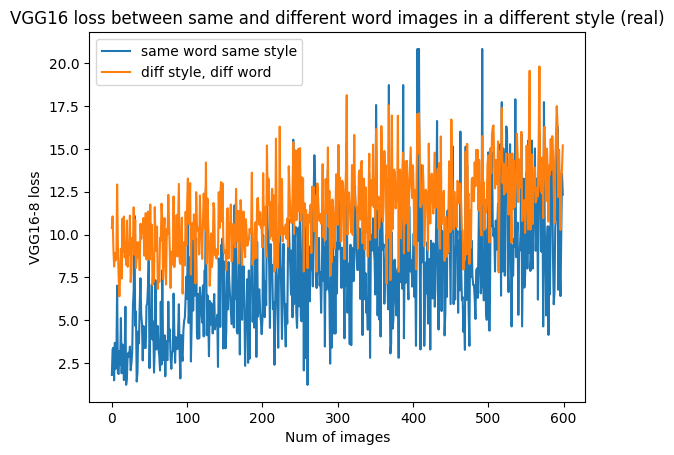

In [ ]:
plt.plot(losses_same_real, label="same word same style")
plt.plot(losses_diff_s_diff_real, label="diff style, diff word")
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-8 loss")
plt.title("VGG16 loss between same and different word images in a different style (real)")
plt.savefig("./vgg_loss_data_real_diff_s_diff_w.png")
plt.show()

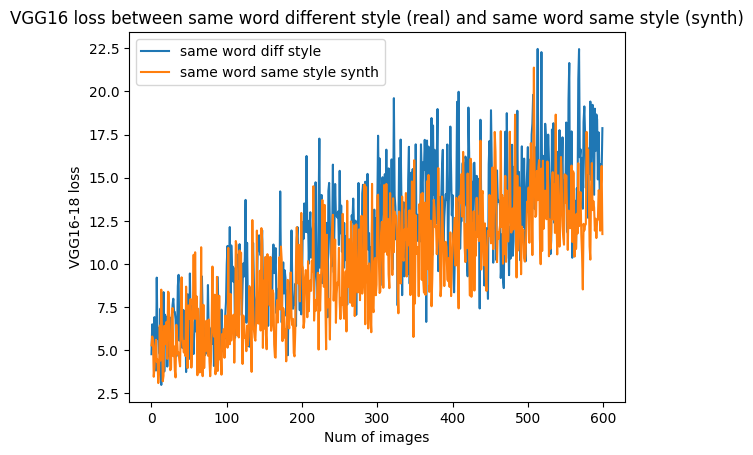

In [ ]:
plt.plot(losses_diff_s_real, label="same word diff style")
plt.plot(losses_same_synth, label="same word same style synth")
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-18 loss")
plt.title("VGG16 loss between same word different style (real) and same word same style (synth)")
plt.savefig("./vgg_loss_data_real_synth_samewdiffs_samewsames.png")
plt.show()

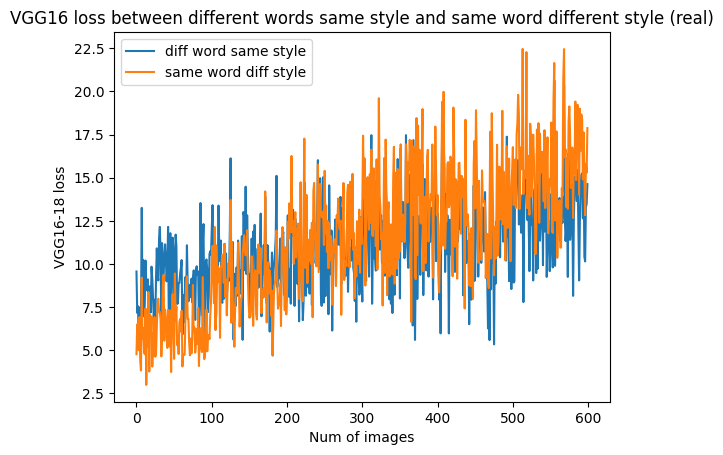

In [ ]:
plt.plot(losses_diff_real, label='diff word same style')
plt.plot(losses_diff_s_real, label="same word diff style")

plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-18 loss")
plt.title("VGG16 loss between different words same style and same word different style (real)")
plt.savefig("./vgg_loss_data_real_diffwsames_samew_diffs.png")
plt.show()